In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import minimize, fsolve
from datetime import datetime

%matplotlib inline

In [2]:
def d(St, K, t, T, r, q, sigma):
    '''
    d2 = d1 - sigma * np.sqrt(T-t)
    '''
    return (np.log(St/K) + (T-t) * (r - q + (sigma ** 2) * 0.5)) / (sigma * np.sqrt(T-t))

def N(d):
    '''
    Standard normal cumulative distribution function.
    e^{-qt} * N(d1) = delta of call option
    e^{-qt} * (N(d1) - 1) = delta of put option
    N(d2) = risk-neutral probability (S_T >= K) i.e. probability option expires ITM
    '''
    return norm.cdf(d)

In [3]:
def BSM_euro_call_value(St, K, t, T, r, q, sigma):
    '''
    Parameters
    -------------
    St: initial stock price
    K: strike price
    t: start date
    T: maturity date
    r: r_f
    q: dividend yield
    sigma: vol
    '''
    
    d1 = d(St, K, t, T, r, q, sigma)
    d2 = d1 - sigma * np.sqrt(T-t)
    
    return St * np.exp(-q * (T-t)) * N(d1) - K * np.exp(-r * (T-t)) * N(d2)

In [4]:
def BSM_euro_put_value(St, K, t, T, r, q, sigma):
    '''
    Parameters
    -------------
    St: initial stock price
    K: strike price
    t: start date
    T: maturity date
    r: r_f
    q: dividend yield
    sigma: vol
    '''
    
    d1 = d(St, K, t, T, r, q, sigma)
    d2 = d1 - sigma * np.sqrt(T-t)
    
    return K * np.exp(-r * (T-t)) * N(-d2) - St * np.exp(-q * (T-t)) * N(-d1)

    # --- alternatively, put option value can be derived from call option value ---
    # BSM_euro_call_value(St, K, t, T, r, q, sigma) - \
    # St * np.exp(-q * (T-t)) + np.exp(-r * (T-t)) * K

In [5]:
def vega(St, K, t, T, r, q, sigma):
    d1 = d(St, K, t, T, r, q, sigma)
    return norm.pdf(d1, 0.0, 1.0) * np.sqrt(T)

In [24]:
def imp_vol(St, K, t, T, r, q, option_val, sigma_est=0.5):
        
    def min_func(sigma_est):
        C0 = BSM_euro_call_value(St, K, t, T, r, q, sigma_est)
        return abs(C0 - option_val)
    
    return fsolve(min_func, x0=sigma_est)[0]

In [25]:
St = 100.0   # index level
K = 100.0    # option strike
t = 0.0      # valuation date
T = 1.0      # maturity date
r = 0.05     # risk-less short rate
q = 0.02     # dividend yield
sigma = 0.2  # volatility

In [26]:
call_val = BSM_euro_call_value(St, K, t, T, r, q, sigma)
impl_vol = imp_vol(St, K, t, T, r, q, 9.2)

print('Call value: {}\nImplied Vol: {}'.format(call_val, impl_vol))

Call value: 9.227005508154036
Implied Vol: 0.19928745938902975


## Call and Put Option Values (Across Various Stock Prices)

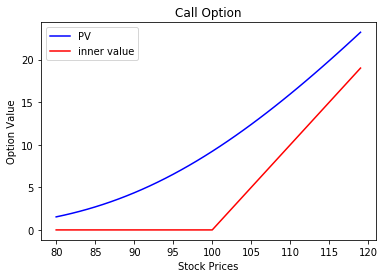

In [9]:
stock_prices = np.arange(80, 120)
call_values = []
terminal_call_values = []
for St in stock_prices:
    call_values.append(BSM_euro_call_value(St, K, t, T, r, q, sigma))
    terminal_call_values.append(max(St-K, 0))
    
plt.plot(stock_prices, call_values, color='b', label='PV')
plt.plot(stock_prices, terminal_call_values, color='r', label='inner value')
plt.xlabel('Stock Prices')
plt.ylabel('Option Value')
plt.title('Call Option')
plt.legend()

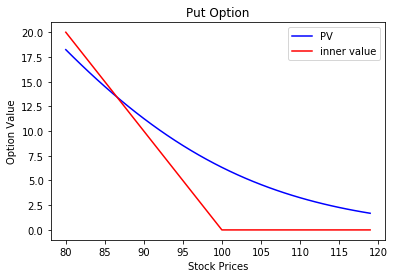

In [10]:
stock_prices = np.arange(80, 120)
put_values = []
terminal_put_values = []
for St in stock_prices:
    put_values.append(BSM_euro_put_value(St, K, t, T, r, q, sigma))
    terminal_put_values.append(max(K-St, 0))
    
plt.plot(stock_prices, put_values, color='b', label='PV')
plt.plot(stock_prices, terminal_put_values, color='r', label='inner value')
plt.xlabel('Stock Prices')
plt.ylabel('Option Value')
plt.title('Put Option')
plt.legend()